# Convert CIF to JCPDS

* This notebook shows how to calculate a theoretical diffraction pattern  using `pymatgen`.  
* This also aims to show how to read `CIF` files, convert them to `JCPDS`.  
* Some `jcpds` files can be downloaded from: https://github.com/SHDShim/JCPDS

In [1]:
%matplotlib inline

## What is CIF file

https://en.wikipedia.org/wiki/Crystallographic_Information_File



In [2]:
%ls ./cif/*.cif

./cif/MgSiO3_bm.cif


In [3]:
%cat ./cif/MgSiO3_bm.cif

data_global
_chemical_name_mineral 'Bridgmanite'
loop_
_publ_author_name
'Horiuchi H'
'Ito E'
'Weidner D J'
_journal_name_full 'American Mineralogist'
_journal_volume 72 
_journal_year 1987
_journal_page_first 357
_journal_page_last 360
_publ_section_title
;
 Perovskite-type MgSiO3: Single-crystal X-ray diffraction study
;
_database_code_amcsd 0001071
_chemical_compound_source 'Synthetic'
_chemical_formula_sum 'Mg Si O3'
_cell_length_a 4.7754
_cell_length_b 4.9292
_cell_length_c 6.8969
_cell_angle_alpha 90
_cell_angle_beta 90
_cell_angle_gamma 90
_cell_volume 162.345
_exptl_crystal_density_diffrn      4.107
_symmetry_space_group_name_H-M 'P b n m'
loop_
_space_group_symop_operation_xyz
  'x,y,z'
  'x,y,1/2-z'
  '-x,-y,1/2+z'
  '1/2+x,1/2-y,1/2+z'
  '1/2-x,1/2+y,1/2-z'
  '1/2-x,1/2+y,z'
  '1/2+x,1/2-y,-z'
  '-x,-y,-z'
loop_
_atom_site_label
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
Mg   0.51410   0.55600   0.25000
Si   0.50000   0.00000   0.50000
O1   0.10280   0.46600   

## What is a JCPDS file

What is lacking in cif?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## What is `pymatgen`?

https://pymatgen.org

In [5]:
import pymatgen as mg
from pymatgen import Lattice, Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [6]:
mg.__version__

'2019.7.30'

This works with `pymatgen` version `2019.4.11` or later.

`ds_jcpds` is written by Dan Shim for making a jcpds file.

In [7]:
import sys
sys.path.append('../../peakpo/')
sys.path.append('../local_modules/')
import ds_jcpds
import quick_plots as quick

## Input parameters

In [8]:
%ls ./cif/

MgSiO3_bm.cif


In [9]:
fn_cif = "./cif/MgSiO3_bm.cif"
fn_jcpds = './jcpds/MgSiO3-bm.jcpds'
comments_jcpds = "Bridgmanite"

Parameters for the equation of state of bridgmanite.

In [10]:
k0 = 260. # 200.
k0p = 4.00 # 4.
alpha = 3.16e-5 # 1.e-5

In [11]:
wl_xray = 0.3344
xrange = (0,40)

## Read CIF

The `cif` file below was downloaded from American mineralogist crystal structure database.

In [12]:
material = mg.Structure.from_file(fn_cif)

## Get some parameters in CIF

In [13]:
print('Unit-cell volume = ', material.volume)
print('Density = ', material.density)
print('Chemical formula = ', material.formula)

Unit-cell volume =  162.345450996792
Density =  4.107275060713392 g cm^-3
Chemical formula =  Mg4 Si4 O12


In [14]:
lattice = material.lattice
print('Lattice parameters = ', lattice.a, lattice.b, lattice.c, \
      lattice.alpha, lattice.beta, lattice.gamma)
crystal_system = SpacegroupAnalyzer(material).get_crystal_system()
print(crystal_system)

Lattice parameters =  4.7754 4.9292 6.8969 90.0 90.0 90.0
orthorhombic


## Get diffraction pattern

In [15]:
c = XRDCalculator(wavelength=wl_xray)

In [16]:
pattern = c.get_pattern(material, two_theta_range = xrange)

## Extract twotheta, d-sp, int, hkl

In [17]:
pattern.hkls[0][0]['hkl']

(1, 0, 1)

In [18]:
pattern.hkls.__len__()

722

In [19]:
h = []; k = []; l = []
for i in range(pattern.hkls.__len__()):
    h.append(pattern.hkls[i][0]['hkl'][0])
    k.append(pattern.hkls[i][0]['hkl'][1])
    l.append(pattern.hkls[i][0]['hkl'][2])

In [20]:
d_lines = [pattern.x, pattern.d_hkls, pattern.y, h, k, l ]
diff_lines = np.transpose(np.asarray(d_lines))
print(diff_lines[1,:])

[5.55821414 3.44845    8.23481259 0.         0.         2.        ]


## Table output

We can make a nice looking table using the `pandas` package.  `pandas` is more than looking-good table producer.  It is a powerful statistics package popular in data science.

In [21]:
table = pd.DataFrame(data = diff_lines,    # values
    columns=['Two Theta', 'd-spacing', 'intensity', 'h', 'k', 'l'])  # 1st row as the column names
table.head()

,Two Theta,d-spacing,intensity,h,k,l
0,4.881525,3.926131,0.815361,1.0,0.0,1.0
1,5.558214,3.448450,8.234813,0.0,0.0,2.0
2,5.588459,3.429802,20.916571,1.0,1.0,0.0
3,6.241956,3.071022,8.938528,1.0,1.0,1.0
4,7.779938,2.464600,24.497625,0.0,2.0,0.0


## Plot peak positions generated from pymatgen

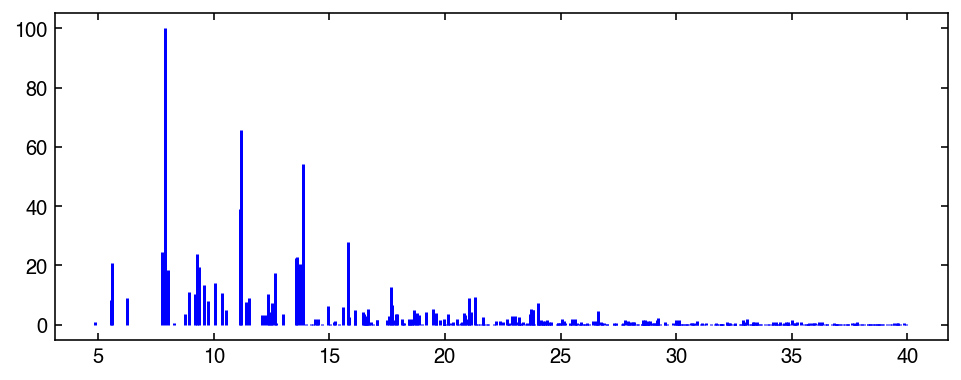

In [22]:
f, ax = plt.subplots(figsize=(8,3))
ax.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b');

## Convert to JCPDS

Setup an `jcpds` object from a `cif` file

In [23]:
material_jcpds = ds_jcpds.JCPDS()
material_jcpds.set_from_cif(fn_cif, k0, k0p, \
                      thermal_expansion=alpha, 
                        two_theta_range=xrange)

Calculate diffraction pattern at a pressure.

In [24]:
material_jcpds.cal_dsp(pressure = 100.)
dl = material_jcpds.get_DiffractionLines()
tth, inten = material_jcpds.get_tthVSint(wl_xray)

(7.5, 9)

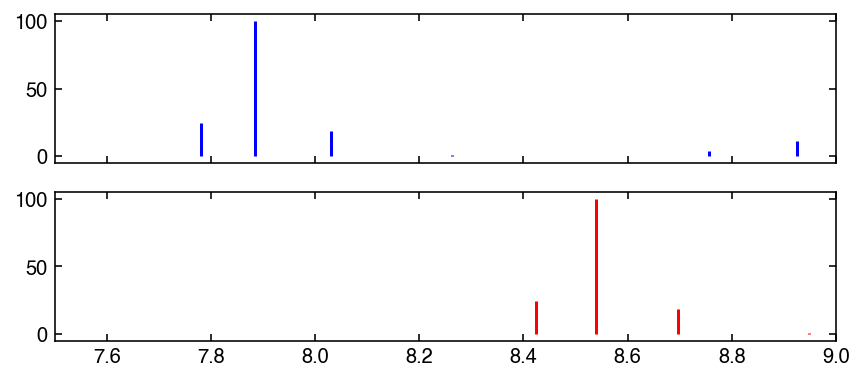

In [25]:
f, ax = plt.subplots(2, 1, figsize=(7,3), sharex=True)
ax[0].vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b')
ax[1].vlines(tth, 0., inten, color = 'r')
ax[0].set_xlim(7.5,9)

## Save to a JCPDS file

In [26]:
material_jcpds.write_to_file(fn_jcpds, comments=comments_jcpds)

In [27]:
%cat {fn_jcpds}

4
Bridgmanite
4 260.00 4.00 
4.77540 4.92920 6.89690 
3.1600e-05 
d-spacing    I/I0     h   k   l 
3.926131 0.82 1.0 0.0 1.0 
3.448450 8.23 0.0 0.0 2.0 
3.429802 20.92 1.0 1.0 0.0 
3.071022 8.94 1.0 1.0 1.0 
2.464600 24.50 0.0 2.0 0.0 
2.431802 100.00 1.0 1.0 2.0 
2.387700 18.57 2.0 0.0 0.0 
2.320866 0.47 0.0 2.0 1.0 
2.190117 3.77 1.0 2.0 0.0 
2.148865 10.92 2.0 1.0 0.0 
2.087399 10.37 1.0 2.0 1.0 
2.071424 23.71 1.0 0.0 3.0 
2.051591 19.61 2.0 1.0 1.0 
2.005137 13.51 0.0 2.0 2.0 
1.963065 8.00 2.0 0.0 2.0 
1.909655 14.02 1.0 1.0 3.0 
1.848773 10.74 1.0 2.0 2.0 
1.823757 5.02 2.0 1.0 2.0 
1.724225 38.99 0.0 0.0 4.0 
1.714901 65.71 2.0 2.0 0.0 
1.681123 7.67 0.0 2.0 3.0 
1.664226 8.88 2.0 2.0 1.0 
1.585732 3.16 1.0 2.0 3.0 
1.569861 3.41 2.0 1.0 3.0 
1.553674 10.26 1.0 3.0 0.0 
1.551026 1.15 3.0 0.0 1.0 
1.540515 4.15 1.0 1.0 4.0 
1.535511 7.41 2.0 2.0 2.0 
1.515691 17.39 1.0 3.0 1.0 
1.514774 0.53 3.0 1.0 0.0 
1.479510 3.70 3.0 1.0 1.0 
1.416541 22.43 1.0 3.0 2.0 
1.412808 22.91 0.0 2

# Read back the written JCPDS for test

In [28]:
material_test = ds_jcpds.JCPDS(filename = fn_jcpds)

Calculate a pattern at a pressure

In [29]:
material_test.cal_dsp(pressure = 100.)
material_test.get_DiffractionLines()
tth, inten = material_test.get_tthVSint(wl_xray)

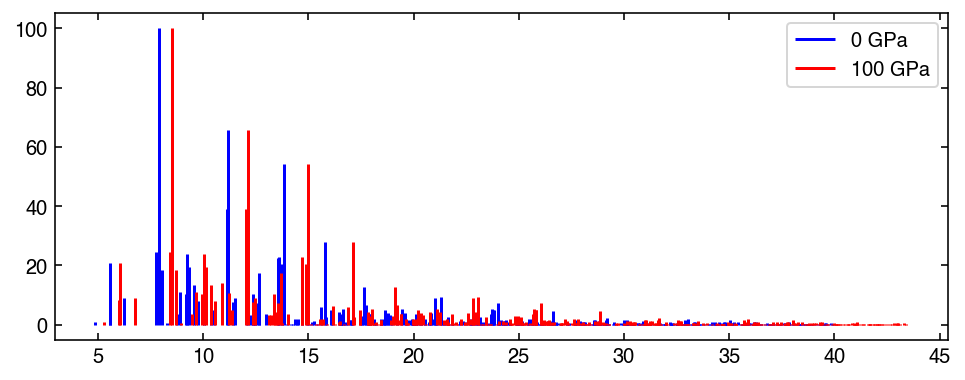

In [30]:
f = plt.figure(figsize=(8,3))
plt.vlines(diff_lines[:,0], 0., diff_lines[:,2], color='b', label='0 GPa')
plt.vlines(tth, 0., inten, color = 'r', label='100 GPa')
plt.legend();